# Object Detection using Meta's DETR

Object detection combines the task of classification and spatial localisation of object on image

In [ ]:
# !pip install transformers
# !pip install timm
# !pip install inflect
# !pip install phonemizer
# !pip install py-espeak-ng

# !apt-get install espeak-ng

In [2]:
from transformers import pipeline
from transformers.utils import logging
logging.set_verbosity_error()

In [ ]:
# creating object detection pipeline from HF
od_pipe = pipeline("object-detection", "facebook/detr-resnet-50")

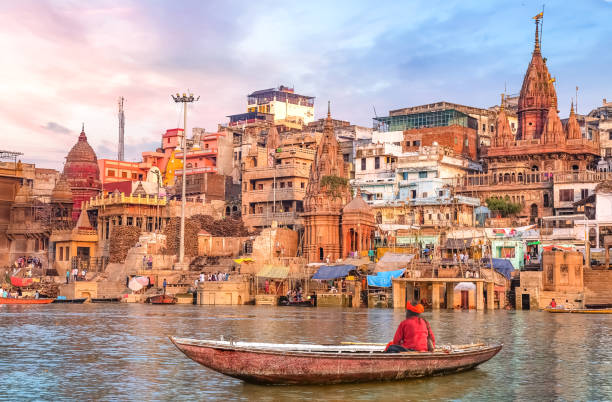

In [26]:
# Preparing Input
from PIL import Image

raw_image = Image.open('varanasi.jpg')
raw_image

In [27]:
# inference
pipeline_output = od_pipe(raw_image)

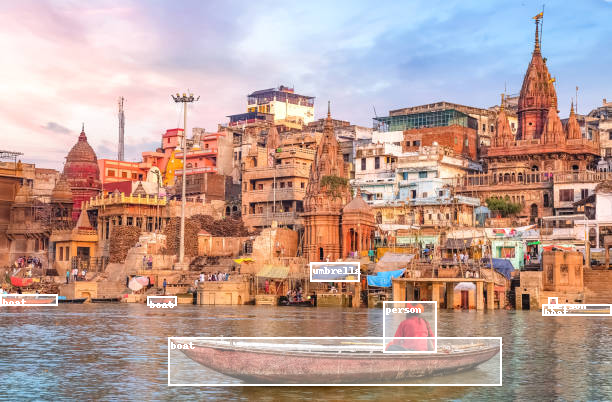

In [35]:
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as transforms
import cv2

boxes = []
labels = []
for box in pipeline_output:
  boxes.append([box['box']['xmin'], box['box']['ymin'], box['box']['xmax'], box['box']['ymax']])
  labels.append(box['label'])

boxes = torch.tensor(boxes, dtype=torch.int)

transform = transforms.Compose([
    transforms.PILToTensor()
])

img = draw_bounding_boxes(
  transform(raw_image),
  boxes,
  labels=labels,
  width=2,
  colors="white",
  fill=True
)
img = transforms.ToPILImage()(img)
img

Lets bring it closer to human and summarize the contents of image in the form of audio

In [37]:
# Helper function from the DLAI course
import inflect

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string

In [38]:
text = summarize_predictions_natural_language(pipeline_output)
text

'In this image, there are four boats two persons and one umbrella.'

In [42]:
# Loading TTS Model
tts_pipe = pipeline("text-to-speech", model="kakao-enterprise/vits-ljs")
narrated_text = tts_pipe(text)

from IPython.display import Audio as IPythonAudio
IPythonAudio(narrated_text["audio"][0], rate=narrated_text["sampling_rate"])